# Generation of System model (all situations)
## Load and merge data

Loading data from pickle files. Each file corresponds to a CrowdNav situation. 

For each situation, 1000 values of the trip overhead are provided for each of the 2^7 = 128 configurations of the full factorial design with 7 factors (the CrowdNav parameters) and 2 levels per factor (min and max values of each parameter). 

There are data from 3 situations:
* 0 regular cars, 750 smart cars
* 400 regular cars, 350 smart cars
* 0 regular cars, 350 smart cars

After loading the data for each configuration for all 3 situations, data are merged per configuration to provide a unified view over the data for a configuration, irrespective of the situation.

In [1]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from factorial_anova_analysis import get_data_and_knobs

strategy_knobs = {
    "route_random_sigma": ([0.0, 0.3], 0.3),
    "exploration_percentage": ([0.0, 0.3], 0.3),
    "max_speed_and_length_factor": ([1.0, 2.5], 1.5),
    "average_edge_duration_factor": ([1.0, 2.5], 1.5),
    "freshness_update_factor": ([5, 20], 15),
    "freshness_cut_off_value": ([100, 700], 600),
    "re_route_every_ticks": ([10, 70], 60),
}

data1, knobs1, exp_count1 = get_data_and_knobs("full_factorial-0_regular_cars-750_smart_cars", strategy_knobs, False)
data2, knobs2, exp_count2 = get_data_and_knobs("full_factorial-400_regular_cars-350_smart_cars", strategy_knobs, False)
data3, knobs3, exp_count3 = get_data_and_knobs("full_factorial-0_regular_cars-350_smart_cars", strategy_knobs, False)

print "exp_count1: " + str(exp_count1)
print "exp_count2: " + str(exp_count2)
print "exp_count3: " + str(exp_count3)

all_data = {}
for i in range(len(data1)): 
    all_data[i] = data1[i] + data2[i] + data3[i]
print "data merged."

all_knobs = {}
for i in range(len(knobs1)): 
    all_knobs[i] = knobs1[i] + knobs2[i] + knobs3[i]
print "knobs merged."

if exp_count1 == exp_count2 == exp_count3:
    exp_count = exp_count1
    print "same number of experiments, can continue!"
else:
    exp_count = None
    print "not the same number of experiments, cannnot continue!"

total_sample_size_per_conf = 3000
if len(all_data[0]) == total_sample_size_per_conf:
    print "Data count is 3000, continue!"

data retrieved from file full_factorial-0_regular_cars-750_smart_cars.pickle
~~~~~~~~~
full_factorial-0_regular_cars-750_smart_cars
~~~~~~~~~
data retrieved from file full_factorial-400_regular_cars-350_smart_cars.pickle
~~~~~~~~~
full_factorial-400_regular_cars-350_smart_cars
~~~~~~~~~
data retrieved from file full_factorial-0_regular_cars-350_smart_cars.pickle
~~~~~~~~~
full_factorial-0_regular_cars-350_smart_cars
~~~~~~~~~
exp_count1: 128
exp_count2: 128
exp_count3: 128
data merged.
knobs merged.
same number of experiments, can continue!
Data count is 3000, continue!


## Factorial ANOVA with variable sample sizes

Here, we randomly sample from the 1000 values per confuiguration and apply factorial ANOVA to the result. 

We increase the size of the sample (by a step of 20) until we reach an ANOVA result where more than 5 effects have 
* alpha < 0.005
* effect size (measured by omega squared metric) > 0.001

In [18]:
from analysis_lib.factorial_tests import FactorialAnova
import random

min_effect_size = 0.001
alpha = 0.0005
fake_id = "123456"
y_key = 'overhead'

for sample_size in range(20, 101, 20):
    print "--------"
    print "Sample size: " + str(sample_size)

    random.seed(123456) 
    
    inds = {}
    for k in all_data.keys():
        inds[k] = random.sample(range(total_sample_size_per_conf), sample_size)

    analysis_data = {}
    for k in all_data.keys(): 
        analysis_data[k] = [all_data[k][i] for i in inds[k]]

    analysis_knobs = {}
    for k in all_knobs.keys(): 
        analysis_knobs[k] = [all_knobs[k][i] for i in inds[k]]

    aov_table = FactorialAnova(fake_id, y_key, strategy_knobs.keys(), exp_count).start(analysis_data, analysis_knobs)

    aov_table = aov_table.sort_values(by='PR(>F)', ascending=True)
    aov_table = aov_table[aov_table["PR(>F)"] < alpha]
    aov_table = aov_table[aov_table["omega_sq"] > min_effect_size]

    probabilities = aov_table["PR(>F)"]
    omega_sqs = aov_table["omega_sq"]

    print str(len(probabilities)) + " interaction were significant."

    if len(probabilities) >= 5:
        print "Sample size: " + str(sample_size)
        print "============="
        print "...stopping here since we found more than 5 significant interactions."
        print probabilities
        print "**********"
        print omega_sqs       
        print "============="
        break

--------
Sample size: 20
0 interaction were significant.
--------
Sample size: 40
1 interaction were significant.
--------
Sample size: 60
3 interaction were significant.
--------
Sample size: 80
1 interaction were significant.
--------
Sample size: 100
5 interaction were significant.
Sample size: 100
...stopping here since we found more than 5 significant interactions.
C(max_speed_and_length_factor)                                                          3.113323e-10
C(freshness_cut_off_value)                                                              6.817630e-08
C(freshness_update_factor)                                                              2.707724e-07
C(freshness_cut_off_value):C(exploration_percentage)                                    4.779269e-05
C(exploration_percentage):C(freshness_update_factor):C(average_edge_duration_factor)    1.369965e-04
Name: PR(>F), dtype: float64
**********
C(max_speed_and_length_factor)                                                    

## ANOVA main effects plots

The main effects of the factorial ANOVA applied in the last step are plotted in line charts. 

route_random_sigma
---------
*******
0's: 6400
*******
0.3's: 6400
exploration_percentage
---------
*******
0's: 6400
*******
0.3's: 6400
max_speed_and_length_factor
---------
*******
1's: 6400
*******
2.5's: 6400
average_edge_duration_factor
---------
*******
1's: 6400
*******
2.5's: 6400
freshness_update_factor
---------
*******
5's: 6400
*******
20's: 6400
freshness_cut_off_value
---------
*******
100's: 6400
*******
700's: 6400
re_route_every_ticks
---------
*******
10's: 6400
*******
70's: 6400


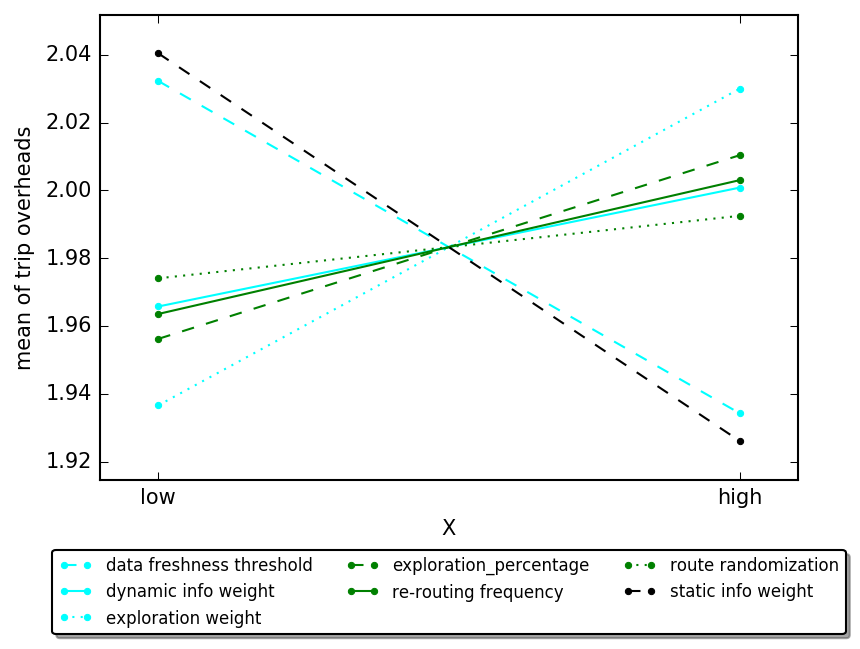

In [19]:
from statsmodels.graphics.factorplots import interaction_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

def get_id_for_knob(knob):
    if knob == "route_random_sigma":
        return "route randomization"
    if knob == "exploration_percentage":
        return "exploration_percentage"
    if knob == "max_speed_and_length_factor":
        return "static info weight"
    if knob == "average_edge_duration_factor":
        return "dynamic info weight"
    if knob == "freshness_update_factor":
        return "exploration weight"
    if knob == "freshness_cut_off_value":
        return "data freshness threshold"
    if knob == "re_route_every_ticks":
        return "re-routing frequency"
    
def get_normalized_list(knob_list):
    l = []
    for knob_v in knob_list: 
        if knob_v == 0:
            l.append(0)
        if knob_v == 1:
            l.append(0)
        if knob_v == 5:
            l.append(0)
        if knob_v == 10:
            l.append(0)
        if knob_v == 100:
            l.append(0)
        if knob_v == 0.3:
            l.append(1)
        if knob_v == 2.5:
            l.append(1)
        if knob_v == 20:
            l.append(1)
        if knob_v == 70:
            l.append(1)
        if knob_v == 700:
            l.append(1)
    return l
   
knob_names = [
    "route_random_sigma",
    "exploration_percentage",
    "max_speed_and_length_factor",
    "average_edge_duration_factor",
    "freshness_update_factor",
    "freshness_cut_off_value",
    "re_route_every_ticks",
]

knob_values = [
    [0, 0.3],     # route_random_sigma
    [0, 0.3],     # exploration_percentage
    [1, 2.5],     # max_speed_and_length_factor
    [1, 2.5],     # average_edge_duration_factor
    [5, 20],      # freshness_update_factor
    [100, 700],   # freshness_cut_off_value
    [10, 70]      # re_route_every_ticks"
]

knobs = {}
data = {}

for j in range(len(knob_names)): 
    knob_name = knob_names[j]
    print "Factor: " + knob_name 
    for i in knob_values[j]:    
        ind = knob_name + ":" + str(i)
        knobs[ind] = []
        data[ind] = []
        for knob_ind in range(len(analysis_knobs)):
            if analysis_knobs[knob_ind][0].get(knob_name)==i:
                knobs[ind] += [i for k in analysis_knobs[knob_ind]]       
                data[ind] += analysis_data[knob_ind]
        print "Level " + str(i)+":\t" + str(len(data[ind])) + " data points"
    print "========="
    
all_knobs = []
for knob_list in knobs.values():
    all_knobs += get_normalized_list(knob_list)

all_traces = []
for k in knobs.keys():
    all_traces += [get_id_for_knob(k.split(":")[0]) for i in range(len(knobs[k]))]

all_data = []
for data_list in data.values():
    all_data += [d["overhead"] for d in data_list]


fig = interaction_plot(all_knobs, all_traces, all_data,
                       linestyles=['--',  '-', ':',  '--',  '-',':', '--',],
                      colors=['cyan', 'cyan', 'cyan', 'green', 'green', 'green', 'black'])
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=3, fancybox=True, shadow=True, prop={'size': 8})
plt.ylabel('mean of trip overheads')
plt.xticks([0,1], ["low", "high"])
plt.show()